Name: Gurjeet Singh

#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [24]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        z_mu, z_var = inputs
        return z_mu + tf.keras.backend.exp(z_var/2) * tf.keras.backend.random_normal(tf.shape(z_var))

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

In [25]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = keras.layers.Dense(512, activation='selu')(encoder_inputs)#[TO COMPLETE]
x = keras.layers.Dense(256, activation='selu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var =  keras.layers.Dense(latent_dim, name="z_var")(x)#[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 512)          401920      input_7[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          131328      dense_15[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 32)           8224        dense_16[0][0]                   
____________________________________________________________________________________________

**Answer**

During the encoding part, we want the model to learn a compressed information of the dataset, but since we using the variational autoencoder we take into consideration the stochasticity property added to the model, thus we encode the data distribution over the latent space by compressing it.
Hence we build the encoding layers by decrementing the number of neurons layer by layer in order to reduce the dimensionality of the latent distribution.
For this reason, I used 512, 256, 32 neurons per layer for the encoding part, hence we end up having a final 32 latent features space from the initial 784. Furthermore, I chose some rectified functions(Selu, Relu which belongs to the same family of rectified activation function) as suggested by the scientific literature, in addition Selu activation function induces self-normalizing properties to the network which helps during the learning phase/backpropagation for $\mu$ and $\Sigma$ parameters of the normal distribution which approximates our used conditional probabilities.
The number of layers chose is 3 as suggested by the exercise.

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

In [26]:
latent_inputs = keras.Input(shape=(latent_dim,))
#...[TO COMPLETE]...
x = keras.layers.Dense(32, activation='relu')(latent_inputs)
x = keras.layers.Dense(256, activation='selu')(x)
x = keras.layers.Dense(512, activation='selu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_19 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_21 (Dense)             (None, 784)               402192    
Total params: 542,320
Trainable params: 542,320
Non-trainable params: 0
_________________________________________________________________


**Answer**

Once we encoded the latent probability distribution $z$ of the input space we build up the decoding layers to reconstruct the input data $x$ into $\hat{x}$, in order to assess if the neural network present the right representation. Thus the architecture of the decoder has to follow the encoder layers but it has to be specular, hence in reverse order. For this reason I started from the 32 feature space until the 512 layer size which corresponds to the first latent encoder layer. Also, the activation functions follow the same approach as the layer size.
Finally, it has been added the last layer which maps the 512 feature map to the original 784 by using the sigmoid activation function in order to have a probability output of the images, as the input.

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [27]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction)) * 784 #proxy the binary cross-entropy 

            kl_loss = -tf.reduce_mean(1+ z_var - tf.square(z_mean) - tf.exp(z_var))/2 #Kullback-Liebler Divergence for the Normal distribution.

            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [28]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 3s 6ms/step - loss: 185.8966 - reconstruction_loss: 182.4162 - kl_loss: 3.4805
Epoch 2/30
391/391 [==============================] - 2s 6ms/step - loss: 162.8517 - reconstruction_loss: 159.5762 - kl_loss: 3.2754
Epoch 3/30
391/391 [==============================] - 2s 6ms/step - loss: 155.9317 - reconstruction_loss: 152.5097 - kl_loss: 3.4220
Epoch 4/30
391/391 [==============================] - 2s 6ms/step - loss: 152.8935 - reconstruction_loss: 149.4074 - kl_loss: 3.4861
Epoch 5/30
391/391 [==============================] - 2s 6ms/step - loss: 150.5837 - reconstruction_loss: 147.0930 - kl_loss: 3.4907
Epoch 6/30
391/391 [==============================] - 2s 6ms/step - loss: 149.1234 - reconstruction_loss: 145.6145 - kl_loss: 3.5089
Epoch 7/30
391/391 [==============================] - 2s 6ms/step - loss: 148.1898 - reconstruction_loss: 144.6391 - kl_loss: 3.5507
Epoch 8/30
391/391 [==============================] - 2s 6ms/step - l

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

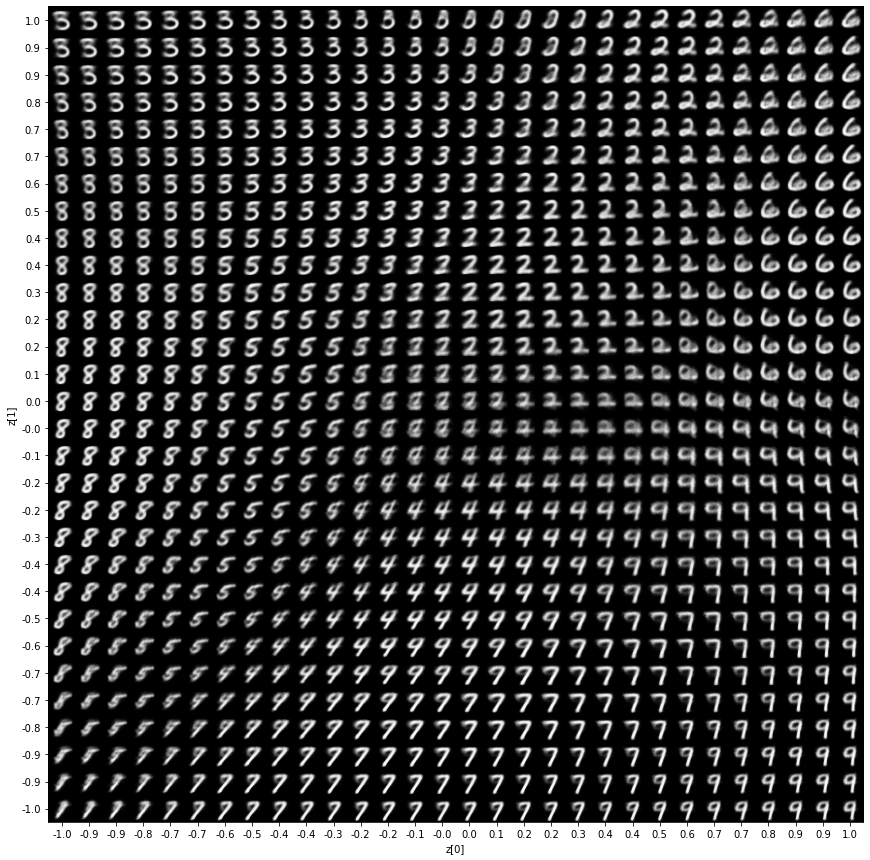

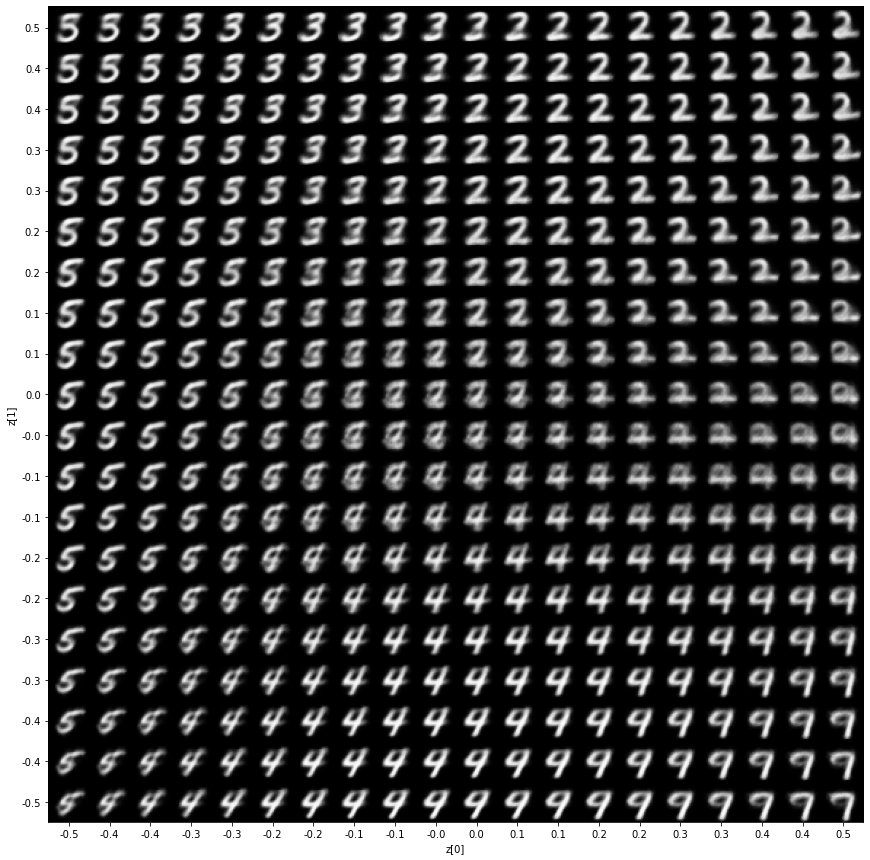

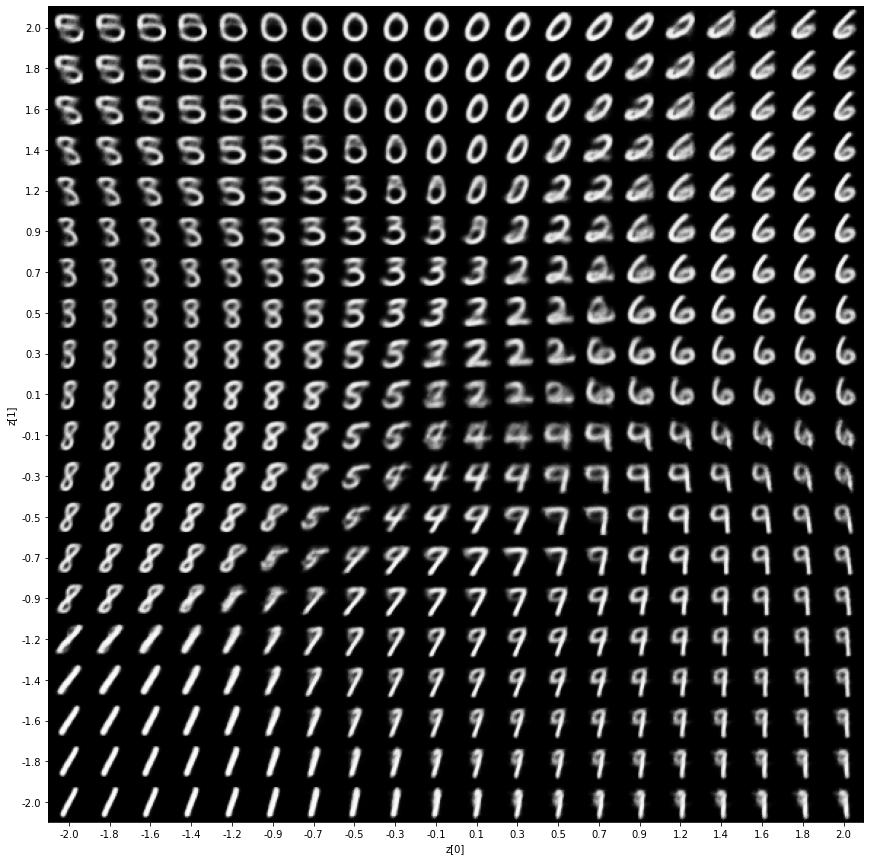

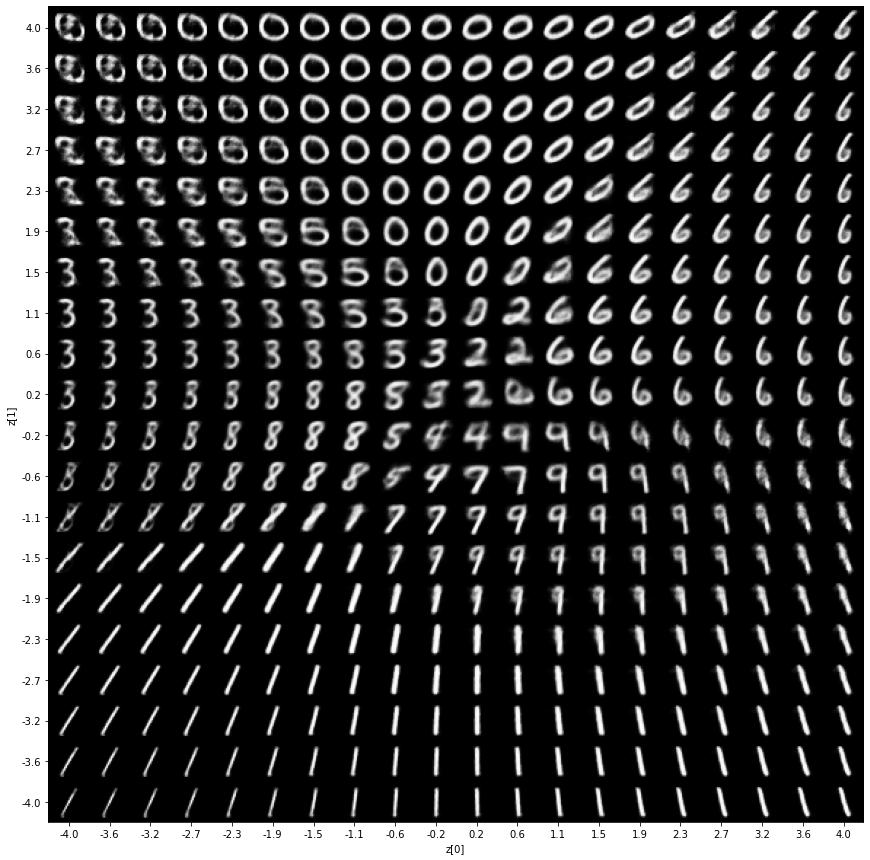

In [29]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 1, 30) 

#[TO COMPLETE] explore with different "scale"
plot_latent(encoder, decoder, 0.5, 20)
plot_latent(encoder, decoder, 2, 20) 
plot_latent(encoder, decoder, 4, 20) 

**Scale**

The **scale** parameter represents the range of the two hidden components $z$ considered, instead the $n$ parameter tells us how many points are considered within the range.
From the above plots, we can see that by changing the scale parameter we can see the mapping manifold of the encoder retrieved by using the decoder. Indeed from the above representation, we can see how changing the two components of the $z$ map, the data mapping keeps changing to similar structures resulting in digits that are very similar to each other. In particular, we can see by taking one point of reference and moving away from it the changes learned by the encoder like rotation, blurring, strokes, new digits.


Let's finally check how the various digits have been rapresented in the latent space by the VAE.

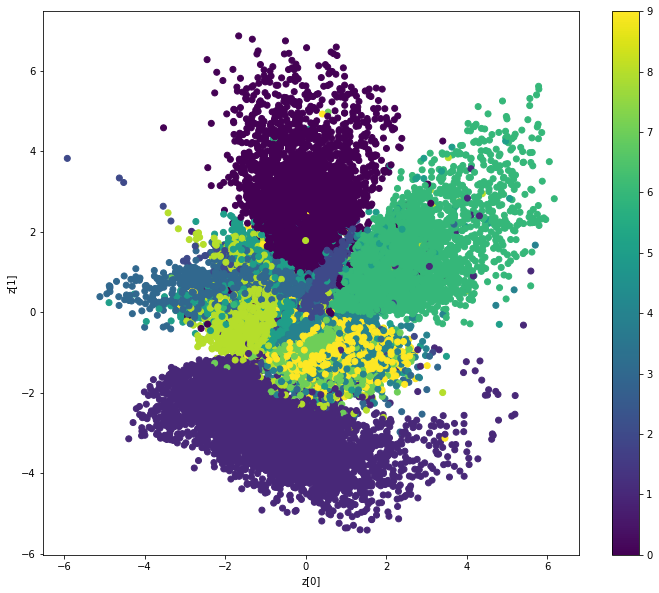

In [30]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.


**Answer**

From the above graph, we can see the encoded compressed information obtained by the encoder after running it on the raw data.
In particular, we can see that just by plotting the first two components of the encoded information we are able to see clusterized data points in the scatter plot. This means that just two components are already highlighting insight information of the data, thus they do hold enough information of the digits in order to define clusters.

It has also to mention that the points that are clusterized close to each other (even if from different classes) are close because they have structurally similar.

**Hyper-parameters Test** 

Arch: 784-512-256-64 - loss: 137.0887 - reconstruction_loss: 133.2794 - kl_loss: 3.8093

Arch: 784-512-256-64-32 - loss: 139.0879 - reconstruction_loss: 135.1284 - kl_loss: 3.9595

**Arch: 784-512-256-32  - loss: 137.6414 - reconstruction_loss: 133.8506 - kl_loss: 3.7907**

Arch: 784-512-256-10 - loss: 140.9496 - reconstruction_loss: 136.7392 - kl_loss: 4.2104

Arch: 784-512-64 - loss: 140.8875 - reconstruction_loss: 137.1715 - kl_loss: 3.7160

Arch: 784-256-64 - loss: 142.6443 - reconstruction_loss: 138.8752 - kl_loss: 3.7690

Arch: 784-256-32 - loss: 141.9138 - reconstruction_loss: 138.2028 - kl_loss: 3.7110

By changing the layer size and the number of layers used by the neural network we can see that the optimal architecture is the 3rd one made of 784-512-256-32 where the total loss (reconstruction + kl_loss) achieves a minimum of 137.64.
We can see that even by incrementing the number of layer to the A.E is not able to perform better representations and loss minimization.
In addition we see that using 32 latent features in the last layer does perform better than 64.
Finally, we can see that by **decreasing** the number of layers in the network from 3 to 2, the network does not reach better local minima and representation. Instead incrementing the layers has not shown such improvement in the results. Thus we can infer that the learned hidden features of the [784-512-256-32] architecture already satisfy our objective.


